# Prediction without Posters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime as dt
import ipywidgets as widgets
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)
import warnings
warnings.simplefilter("ignore")

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

movies = pd.read_csv("../data/movies_with_words.csv")
movies.head()

,adult,backdrop_path,id,original_language,original_title,overview,popularity,poster_path,release_date,title,...,music,which,soon,know,them,wing,comedy,form,test,mall
0,0,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,299536,en,Avengers: Infinity War,as the avengers and their allies have continue...,153.811,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,2018-04-25,Avengers: Infinity War,...,0,0,0,0,1,0,0,0,0,0
1,0,/5zfVNTrkhMu673zma6qhFzG01ig.jpg,300668,en,Annihilation,a biologist signs up for a dangerous secret e...,29.516,/d3qcpfNwbAMCNqWDHzPQsUYiUgS.jpg,2018-02-22,Annihilation,...,0,0,0,0,0,0,0,0,0,0
2,0,/zjG95oDnBcFKMPgBEmmuNVOMC90.jpg,299782,en,The Other Side of the Wind,surrounded by fans and skeptics grizzled dire...,6.820,/kFky1paYEfHxfCYByEc9g7gn6Zk.jpg,2018-11-02,The Other Side of the Wind,...,0,0,0,0,0,0,0,0,0,0
3,0,/q9hnJ9SzwcF30seRtXEzLd5l1gw.jpg,351044,en,Welcome to Marwen,when a devastating attack shatters mark hoganc...,61.973,/o45VIAUYDcVCGuzd43l8Sr5Dfti.jpg,2018-12-21,Welcome to Marwen,...,0,0,0,1,0,0,0,0,1,0
4,0,/AmO8I38bkHwKhgxPNrd6djBQyPU.jpg,361292,en,Suspiria,a darkness swirls at the center of a world ren...,41.461,/dzWTnkert9EoiPWldWJ15dnfAFl.jpg,2018-10-11,Suspiria,...,0,0,0,0,0,0,0,0,0,0


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# split into training and test sets
train, test = train_test_split(movies)

The function `process_data` processes the dataset so that it can be used for modeling.

In [4]:
def process_data(data, features):
    """
    Processes input data for linear regression model, returns feature 
    matrix `X` and array of actual values `y`
    
    Args:
        data     - dataframe with the data
        features - columns of features to choose
    """
    data = data.dropna(subset=["overview_len"])
    
    data = pd.get_dummies(data,
                          prefix = "wkdy",
                          columns = ["day_of_week"],
                          drop_first = True
                         )
        
    X = data[features]
    y = data["rating"]
    return X, y

`features` contains the features of interest.

In [5]:
features = ['adult', 'popularity', 'vote_count',
       'Action', 'Adventure', 'Animation', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'overview_len', 'month',
       'day', 'wkdy_Sun', 'wkdy_Mon', 'wkdy_Tue', 'wkdy_Wed', 'wkdy_Thu', 'wkdy_Sat', 
       'this', 'after', 'known','side', 'killer', 'business', 'seem', 'follows', 'become', 'house',
       'meets', 'aunt', 'each', 'making', 'place', 'only', 'foot',
       'perform', 'lore', 'give', 'found', 'front', 'women', 'ours',
       'behind', 'kill', 'attempt', 'disco', 'mysterious', 'king', 'less',
       'turn', 'begin', 'years', 'range', 'discover', 'through', 'take',
       'group', 'film', 'gain', 'great', 'trip', 'care', 'couple', 'even',
       'party', 'cove', 'down', 'dire', 'story', 'father', 'disc',
       'under', 'ller', 'busi', 'direct', 'light', 'does', 'dangerous',
       'break', 'evil', 'host', 'survive', 'meet', 'realize', 'murder',
       'college', 'documentary', 'self', 'super', 'across', 'cover',
       'rough', 'cross', 'hard', 'brother', 'childhood', 'small',
       'director', 'feat', 'danger', 'dang', 'between', 'mean',
       'christmas', 'year', 'press', 'ross', 'dark', 'follow', 'document',
       'first', 'brea', 'anger', 'strange', 'hunt', 'secret', 'takes',
       'fall', 'music', 'which', 'soon', 'know', 'them', 'wing', 'comedy',
       'form', 'test', 'mall']

In [6]:
X_train, y_train = process_data(train, features)
X_test, y_test = process_data(test, features)

We defined `rmse` and `mae` as error metrics.

In [7]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))

In [8]:
def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))

The functions below are useful for cross-validation and hyperparameter search.

In [9]:
def select_features(selector):
    if selector is None:
        return X_train.columns
    return X_train.columns[SelectKBest(selector).fit(X_train, y_train).get_support()]

In [10]:
def hparam_search(model, X, y, error_fn=mae, **hparams):
    cv = GridSearchCV(model, hparams, n_jobs=-1)
    cv.fit(X, y)
    return cv.best_estimator_, error_fn(cv.best_estimator_.predict(X), y_train)

In [11]:
def run_feature_selection_and_tuning(model, selector, error_fn=mae, **hparams):
    X = X_train[select_features(selector)]
    return hparam_search(model, X, y_train, error_fn=error_fn, **hparams)

The cells below perform feature selection and cross-validation to determine the best model and its parameters.

In [14]:
for s in [None, chi2, f_classif, lambda X, y: mutual_info_classif(X, y, random_state=42)]:
    print(run_feature_selection_and_tuning(
        RidgeClassifier(), 
        s,
        alpha=np.append(0, 10**np.arange(-20, 3, dtype=float))
    ))

NameError: name 'GridSearchCV' is not defined

In [126]:
for s in [None, chi2, f_classif, lambda X, y: mutual_info_classif(X, y, random_state=42)]:
    print(run_feature_selection_and_tuning(
        SVC(random_state=42), 
        s,
        C=10**np.arange(-9, 3, dtype=float)
    ))

(SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False), 0.0)
(SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False), 0.0)
(SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False), 1.1599783080260304)
(SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False), 0.0)


In [122]:
for s in [None, chi2, f_classif, lambda X, y: mutual_info_classif(X, y, random_state=42)]:
    print(run_feature_selection_and_tuning(
        DecisionTreeClassifier(random_state=42), 
        s
    ))

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'), 0.0)
(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'), 0.0)
(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, pr

In [130]:
for s in [None, chi2, f_classif, lambda X, y: mutual_info_classif(X, y, random_state=42)]:
    print(run_feature_selection_and_tuning(
        KNeighborsClassifier(), 
        s,
        n_neighbors=np.arange(1, 20, 2)
    ))

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'), 0.0)
(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'), 0.0)
(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'), 0.32483731019522777)
(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform'), 0.0)


In [159]:
test_errors = {}

def get_test_errors(model, selector):
    model_name = repr(model).split("(")[0]
    if selector is None:
        selector_name = "None"
    else:
        selector_name = repr(selector).split(" ")[1]
        if selector_name == "<lambda>":
            selector_name = "mutual_info_classif"
        
    if model_name not in test_errors:
        test_errors[model_name] = {}
    if selector_name not in test_errors[model_name]:
        test_errors[model_name][selector_name] = {}
    
    X = X_train[select_features(selector)]
    model.fit(X, y_train)
    pred = model.predict(X_test[select_features(selector)])
    test_errors[model_name][selector_name]["MAE"] = mae(y_test, pred)
    test_errors[model_name][selector_name]["RMSE"] = rmse(y_test, pred)

In [160]:
for model in [RidgeClassifier(alpha=0), SVC(random_state=42, C=100), 
              DecisionTreeClassifier(random_state=42), KNeighborsClassifier(n_neighbors=1)]:
    for s in [None, chi2, f_classif, lambda X, y: mutual_info_classif(X, y, random_state=42)]:
        get_test_errors(model, s)

In [161]:
pd.DataFrame(test_errors)

,DecisionTreeClassifier,KNeighborsClassifier,RidgeClassifier,SVC
None,"{'MAE': 0.9560975609756097, 'RMSE': 1.94309283...","{'MAE': 1.078048780487805, 'RMSE': 1.945183754...","{'MAE': 1.4601626016260163, 'RMSE': 2.14438195...","{'MAE': 0.9577235772357724, 'RMSE': 1.80288837..."
chi2,"{'MAE': 1.0178861788617886, 'RMSE': 2.01377370...","{'MAE': 1.0796747967479674, 'RMSE': 1.96638416...","{'MAE': 1.3626016260162601, 'RMSE': 1.98449272...","{'MAE': 0.9056910569105691, 'RMSE': 1.76460226..."
f_classif,"{'MAE': 1.1447154471544716, 'RMSE': 2.15270674...","{'MAE': 1.1869918699186992, 'RMSE': 2.20420883...","{'MAE': 1.3853658536585365, 'RMSE': 2.03385972...","{'MAE': 1.4357723577235773, 'RMSE': 2.15836433..."
mutual_info_classif,"{'MAE': 1.0308943089430895, 'RMSE': 1.96886331...","{'MAE': 1.0861788617886179, 'RMSE': 1.96803727...","{'MAE': 1.469918699186992, 'RMSE': 2.046611317...","{'MAE': 0.8715447154471545, 'RMSE': 1.72499558..."


SVC with mutual_info_classif performs best

In [163]:
test_errors["SVC"]["mutual_info_classif"]

{'MAE': 0.8715447154471545, 'RMSE': 1.724995581471895}

In [165]:
for m in test_errors:
    for s in test_errors[m]:
        for e in test_errors[m][s]:
            test_errors[m][s][e] = np.round(test_errors[m][s][e], 5)

In [166]:
test_errors

{'DecisionTreeClassifier': {'None': {'MAE': 0.9561, 'RMSE': 1.94309},
  'chi2': {'MAE': 1.01789, 'RMSE': 2.01377},
  'f_classif': {'MAE': 1.14472, 'RMSE': 2.15271},
  'mutual_info_classif': {'MAE': 1.03089, 'RMSE': 1.96886}},
 'KNeighborsClassifier': {'None': {'MAE': 1.07805, 'RMSE': 1.94518},
  'chi2': {'MAE': 1.07967, 'RMSE': 1.96638},
  'f_classif': {'MAE': 1.18699, 'RMSE': 2.20421},
  'mutual_info_classif': {'MAE': 1.08618, 'RMSE': 1.96804}},
 'RidgeClassifier': {'None': {'MAE': 1.46016, 'RMSE': 2.14438},
  'chi2': {'MAE': 1.3626, 'RMSE': 1.98449},
  'f_classif': {'MAE': 1.38537, 'RMSE': 2.03386},
  'mutual_info_classif': {'MAE': 1.46992, 'RMSE': 2.04661}},
 'SVC': {'None': {'MAE': 0.95772, 'RMSE': 1.80289},
  'chi2': {'MAE': 0.90569, 'RMSE': 1.7646},
  'f_classif': {'MAE': 1.43577, 'RMSE': 2.15836},
  'mutual_info_classif': {'MAE': 0.87154, 'RMSE': 1.725}}}

In [12]:
selected_X_train  = X_train[select_features(lambda X, y: mutual_info_classif(X, y, random_state=42))]
model = SVC(random_state=42, C=100)
model.fit(selected_X_train, y_train)
y_pred = model.predict(X_test[select_features(lambda X, y: mutual_info_classif(X, y, random_state=42))])

In [13]:
selected_X_train.columns

Index(['popularity', 'vote_count', 'Horror', 'Thriller', 'overview_len', 'day',
       'wkdy_Sun', 'turn', 'strange', 'fall'],
      dtype='object')

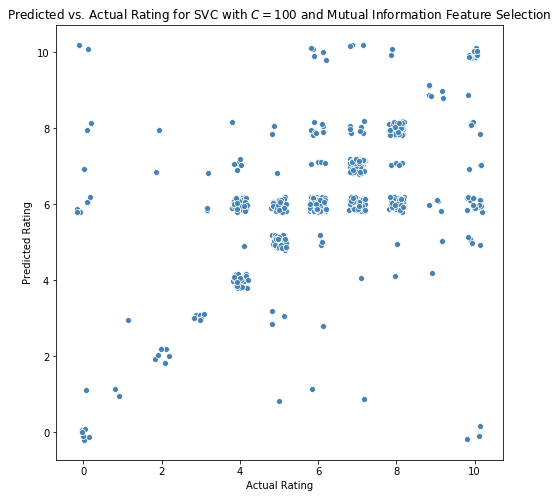

In [18]:
plt.figure(figsize=[8,8])
x_jitter = np.random.uniform(-0.2, 0.2, len(y_test))
y_jitter = np.random.uniform(-0.2, 0.2, len(y_test))
sns.scatterplot(y_test + x_jitter, y_pred + y_jitter, color="steelblue")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title(r"Predicted vs. Actual Rating for SVC with $C=100$ and Mutual Information Feature Selection")
plt.savefig("../figures/no_poster_test_results.png");